# File and Data Field Descriptions

* train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
    - PassengerId - Уникальный идентификатор для каждого пассажира. Каждый идентификатор принимает форму gggg_pp, где gggg указывает группу, с которой путешествует пассажир, а pp — его номер в группе. Люди в группе часто являются членами семьи, но не всегда.
    - HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
    - CryoSleep - Указывает, решил ли пассажир быть помещенным в анабиоз на время рейса. Пассажиры, находящиеся в криосонном состоянии, находятся в своих каютах.
    - Cabin - Номер каюты, в которой находится пассажир. Принимает форму палуба/число/сторона, где сторона может быть либо P для левого борта, либо S для правого борта.
    -  - Планета, на которую будет высаживаться пассажир.
    - Age - The age of the passenger.
    - VIP - Оплатил ли пассажир специальное VIP-обслуживание во время рейса.
    - RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
    - Name - The first and last names of the passenger.
    - Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

* test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.

* sample_submission.csv - A submission file in the correct format.
    - PassengerId - Id for each passenger in the test set.
    - Transported - The target. For each passenger, predict either True or False.

In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# from dataprep.eda import create_report

In [5]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5


In [6]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [7]:
from nltk.corpus import names
import nltk
import random

#-----------------------------------------------------------------------------------------
# FEATURE GENERATION: GENDER
#-----------------------------------------------------------------------------------------

def gender_features(word):
    return {'last_letter':word[-1]}
  
# preparing a list of examples and corresponding class labels.
labeled_names = ([(name, 'male') for name in names.words('male.txt')]+
             [(name, 'female') for name in names.words('female.txt')])
  
random.shuffle(labeled_names)
  
# we use the feature extractor to process the names data.
featuresets = [(gender_features(n), gender) 
               for (n, gender)in labeled_names]
  
# Divide the resulting list of feature
# sets into a training set and a test set.
train_set, test_set = featuresets[500:], featuresets[:500]
  
# The training set is used to 
# train a new "naive Bayes" classifier.
classifier = nltk.NaiveBayesClassifier.train(train_set)
  
    
def get_gender(name):
    return classifier.classify(gender_features(name))    

In [8]:
#-----------------------------------------------------------------------------------------
# FEATURE IMPORTANCE
#-----------------------------------------------------------------------------------------

def plot_feature_importance (estimator_object, X_train, y_train):

    model = estimator_object
    model.fit(X_train, y_train)  


    feature_importance = model.feature_importances_

    # Make importance relative to max_importance

    feature_importance = 100.0 * (feature_importance / feature_importance.max())

    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    plt.figure(figsize=(8, 18))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X_train.keys()[sorted_idx])  #!!!!!

    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')

    plt.show()

In [9]:
#---------------------------------------------------------------------------------------------
# Target encoding done the right way
# https://maxhalford.github.io/blog/target-encoding/
#---------------------------------------------------------------------------------------------

def calc_smooth_mean(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return df[by].map(smooth)

def calc_smooth_mean_for_column(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    return (counts * means + m * mean) / (counts + m)


In [17]:
train_df = pd.read_csv('~/TestProj/ML/Spaceship_Titanic/Data/train.csv')
test_df  = pd.read_csv('~/TestProj/ML/Spaceship_Titanic/Data/test.csv')

transported = train_df['Transported']
transported = transported.apply(lambda r: 1 if r else 0)

submission_df = pd.DataFrame(test_df.loc[:, 'PassengerId'])

# train_df.drop(['Transported'], axis = 1, inplace=True)

all_dataframes = [train_df, test_df]

In [11]:
# create_report(train_df)

In [18]:
for df in all_dataframes:
    
#   PassengerId - Уникальный идентификатор для каждого пассажира. 
#     Каждый идентификатор принимает форму gggg_pp, где gggg указывает группу, 
#     с которой путешествует пассажир, а pp — его номер в группе
    
    df['PassengerGroup'] = df['PassengerId'].apply(lambda r: r[:4])
    df['NumberInGroup']  = df['PassengerId'].apply(lambda r: r[-2:])
    
#   Cabin - Номер каюты, в которой находится пассажир. 
#     Принимает форму палуба/число/сторона, где сторона может быть либо P для левого борта, 
#     либо S для правого борта.  
    
    df['CabinDesk'] = df['Cabin'].apply(lambda r: r.split('/')[0] if r == r else np.nan)
    df['CabinNum'] = df['Cabin'].apply(lambda r: r.split('/')[1] if r == r else np.nan)
    df['CabinSide'] = df['Cabin'].apply(lambda r: r.split('/')[2] if r == r else np.nan)
    
#   Name - The first and last names of the passenger.
    
#     df['PassengerName'] = df['Name'].apply(lambda r: r.split()[0] if r == r else np.nan)
#     df['PassengerSurName'] = df['Name'].apply(lambda r: r.split()[1] if r == r else np.nan)
    
#   Размер группы, в которой состоит пассажир

    data_per_group = df.groupby('PassengerGroup')
    group_size = data_per_group['PassengerId'].count()    
    df['GroupSize'] = df['PassengerGroup'].apply(lambda r: group_size[r])


In [19]:
payment_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for df in all_dataframes:

    # Вспомогательная колонка: сумма платежей

    df['PaymentSumm'] = df.apply(lambda r: r[payment_columns].sum(), axis=1)
    df['PaymentSumm'].isna().any()

    df.loc[(df['CryoSleep'].isna()) & (df['PaymentSumm'] == 0), 'CryoSleep'] = True
    df['CryoSleep'].fillna(False, inplace=True)



    # Если payment_columns.isna() - для CryoSleep = True заполняем 0
    df.loc[(df['CryoSleep']), payment_columns] = 0

    # для CryoSleep = false заполняем 0 (пока...)
    for col in payment_columns:        
        df[col] = df[col].fillna(0)  
    

In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     8693 non-null   object 
 1   HomePlanet      8492 non-null   object 
 2   CryoSleep       8693 non-null   bool   
 3   Cabin           8494 non-null   object 
 4   Destination     8511 non-null   object 
 5   Age             8514 non-null   float64
 6   VIP             8490 non-null   object 
 7   RoomService     8693 non-null   float64
 8   FoodCourt       8693 non-null   float64
 9   ShoppingMall    8693 non-null   float64
 10  Spa             8693 non-null   float64
 11  VRDeck          8693 non-null   float64
 12  Name            8493 non-null   object 
 13  Transported     8693 non-null   bool   
 14  PassengerGroup  8693 non-null   object 
 15  NumberInGroup   8693 non-null   object 
 16  CabinDesk       8494 non-null   object 
 17  CabinNum        8494 non-null   o

In [28]:
age_isna_index = train_df[train_df['Age'].isna()].index

In [40]:
train_df.loc[age_isna_index]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerGroup,NumberInGroup,CabinDesk,CabinNum,CabinSide,GroupSize,PaymentSumm
50,0052_01,Earth,False,G/6/S,TRAPPIST-1e,NaN,False,4.0,0.0,2.0,4683.0,0.0,Elaney Hubbarton,False,0052,01,G,6,S,1,4689.0
64,0068_01,Mars,False,E/4/S,TRAPPIST-1e,NaN,False,793.0,0.0,2.0,253.0,0.0,Cinst Binie,False,0068,01,E,4,S,1,1048.0
137,0149_01,Earth,True,G/27/S,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Billya Hubbarrison,True,0149,01,G,27,S,1,0.0
181,0202_02,Europa,False,A/2/P,55 Cancri e,NaN,False,0.0,2433.0,0.0,878.0,443.0,Vegas Embleng,True,0202,02,A,2,P,2,3754.0
184,0206_01,Europa,False,C/9/S,55 Cancri e,NaN,False,2.0,1720.0,12.0,1125.0,122.0,Nuson Brugashed,True,0206,01,C,9,S,1,2981.0
249,0275_01,Europa,True,D/9/S,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Terf Obnoble,True,0275,01,D,9,S,1,0.0
282,0313_02,Earth,True,G/50/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jona Mckinsond,True,0313,02,G,50,P,4,0.0
325,0365_01,Earth,False,G/51/S,55 Cancri e,NaN,False,0.0,0.0,0.0,685.0,21.0,Dandra Jacostaney,False,0365,01,G,51,S,1,706.0
381,0423_01,Europa,False,B/19/P,TRAPPIST-1e,NaN,False,8.0,3584.0,0.0,13.0,57.0,Syrmark Pumbody,True,0423,01,B,19,P,1,3662.0
434,0465_02,Earth,False,E/28/P,TRAPPIST-1e,NaN,False,0.0,654.0,22.0,146.0,4.0,Kyley Chaellerty,True,0465,02,E,28,P,2,826.0


In [44]:
test_df_age_isna_index = test_df[test_df['Age'].isna()].index

In [45]:
test_df.loc[test_df_age_isna_index]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,PassengerGroup,NumberInGroup,CabinDesk,CabinNum,CabinSide,GroupSize,PaymentSumm
42,0100_01,Earth,False,G/13/P,TRAPPIST-1e,NaN,NaN,0.0,17.0,997.0,0.0,0.0,Dary Cochrisons,0100,01,G,13,P,2,1014.0
68,0156_01,Mars,True,F/34/P,TRAPPIST-1e,NaN,False,0.0,0.0,0.0,0.0,0.0,Tures Upead,0156,01,F,34,P,1,0.0
146,0319_02,Mars,True,F/69/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Pigars Prie,0319,02,F,69,P,2,0.0
157,0339_05,Earth,True,G/56/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Davisy Colleruces,0339,05,G,56,P,8,0.0
211,0467_02,Mars,True,D/17/P,TRAPPIST-1e,NaN,False,0.0,0.0,0.0,0.0,0.0,Cings Keen,0467,02,D,17,P,4,0.0
328,0717_03,Europa,True,B/31/P,NaN,NaN,False,0.0,0.0,0.0,0.0,0.0,Nesch Panspic,0717,03,B,31,P,7,0.0
334,0720_02,Mars,False,E/52/S,TRAPPIST-1e,NaN,False,0.0,0.0,0.0,0.0,0.0,Krus Buko,0720,02,E,52,S,3,0.0
339,0725_01,Earth,True,G/110/P,PSO J318.5-22,NaN,False,0.0,0.0,0.0,0.0,0.0,Joycey Hewson,0725,01,G,110,P,1,0.0
488,1050_01,NaN,True,G/157/P,TRAPPIST-1e,NaN,False,0.0,0.0,0.0,0.0,0.0,Evendy Buchansen,1050,01,G,157,P,1,0.0
547,1137_01,Europa,False,E/82/S,TRAPPIST-1e,NaN,False,0.0,1537.0,0.0,112.0,753.0,Vindem Unings,1137,01,E,82,S,2,2402.0


In [37]:
import datawig

In [47]:
df = datawig.utils.generate_df_numeric( num_samples=200, 
                                        data_column_name='x', 
                                        label_column_name='y')  

In [48]:
df

,x,y
0,-0.788288,0.614597
1,2.831922,8.022102
2,1.457661,2.127706
3,0.619890,0.377120
4,-2.161299,4.689869
5,-2.161450,4.676605
6,-2.776643,7.697831
7,2.300753,5.300028
8,0.635324,0.393890
9,1.307359,1.717057


In [49]:
df_train, df_test = datawig.utils.random_split(df)

In [50]:
df_test

,x,y
57,-1.910196,3.687376
31,-2.070158,4.290379
65,0.268267,0.069599
140,2.905642,8.436862
89,-0.174579,0.029330
158,-1.648472,2.715283
30,0.675724,0.445894
86,1.442658,2.074645
92,1.638561,2.672878
141,-1.559598,2.440841


In [56]:
datawig.

SyntaxError: invalid syntax (1183875924.py, line 1)

In [51]:
#Initialize a SimpleImputer model

imputer = datawig.SimpleImputer(
    input_columns=['CryoSleep'],                         # column(s) containing information about the column we want to impute
    output_column= 'Age',                                  # the column we'd like to impute values for
    output_path = 'imputer_model'                          # stores model data and metrics
    )

In [52]:
# Fit an imputer model on the train data

imputer.fit(train_df=train_df, num_epochs=50)

[20:31:48] ../src/executor/graph_executor.cc:1991: Subgraph backend MKLDNN is activated.
2022-11-15 20:31:48,466 [INFO]  
========== start: fit model
2022-11-15 20:31:48,467 [WARNING]  Already bound, ignoring bind()
2022-11-15 20:31:48,690 [INFO]  Epoch[0] Batch [0-245]	Speed: 18023.50 samples/sec	cross-entropy=16.295914	Age-accuracy=0.308943
2022-11-15 20:31:48,870 [INFO]  Epoch[0] Train-cross-entropy=16.422905
2022-11-15 20:31:48,871 [INFO]  Epoch[0] Train-Age-accuracy=0.345679
2022-11-15 20:31:48,871 [INFO]  Epoch[0] Time cost=0.401
2022-11-15 20:31:48,877 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2022-11-15 20:31:48,900 [INFO]  Epoch[0] Validation-cross-entropy=15.610590
2022-11-15 20:31:48,901 [INFO]  Epoch[0] Validation-Age-accuracy=0.000000
2022-11-15 20:31:49,107 [INFO]  Epoch[1] Batch [0-245]	Speed: 19356.67 samples/sec	cross-entropy=16.130261	Age-accuracy=0.308943
2022-11-15 20:31:49,288 [INFO]  Epoch[1] Train-cross-entropy=16.378159
2022-11-15 20:31:49,28

In [53]:
#Impute missing values and return original dataframe with predictions

imputed = imputer.predict(test_df)

AttributeError: 'Index' object has no attribute 'contains'

In [82]:
#
# Fillna object column
#
for df in all_dataframes:
    
    df['HomePlanet'] = df['HomePlanet'].fillna('Earth')
    df['CabinDesk']  = df['CabinDesk'].fillna('F')
    df['CabinSide']  = df['CabinSide'].fillna('P')

In [14]:
# smooth_HomePlanet = calc_smooth_mean_for_column(train_df, 'HomePlanet', 'Transported', m=10)
# smooth_CabinDesk = calc_smooth_mean_for_column(train_df, 'CabinDesk', 'Transported', m=10)
# smooth_CabinSide = calc_smooth_mean_for_column(train_df, 'CabinSide', 'Transported', m=10)
# smooth_CryoSleep = calc_smooth_mean_for_column(train_df, 'CryoSleep', 'Transported', m=10)

# test_df['HomePlanet'] = test_df['HomePlanet'].map(smooth_HomePlanet)
# test_df['CabinDesk'] = test_df['CabinDesk'].map(smooth_CabinDesk)
# test_df['CabinSide'] = test_df['CabinSide'].map(smooth_CabinSide)
# test_df['CryoSleep'] = test_df['CryoSleep'].map(smooth_CryoSleep)

In [83]:
columns_for_calc_smooth_mean = ['HomePlanet', 'CabinDesk', 'CabinSide', 'CryoSleep']

In [84]:
# calc_smooth_mean_for test_df

for col in columns_for_calc_smooth_mean:  
    
    smooth_for_col = calc_smooth_mean_for_column(train_df, col, 'Transported', m=10)
    test_df[col] = test_df[col].map(smooth_for_col)

In [85]:
# calc_smooth_mean_for train_df

for col in columns_for_calc_smooth_mean:
    
    train_df[col] = calc_smooth_mean(train_df, by=col, on='Transported', m=10)

In [86]:
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,PassengerGroup,NumberInGroup,CabinDesk,CabinNum,CabinSide,GroupSize,PaymentSumm
0,0013_01,0.427807,0.813684,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,0013,01,0.516168,3,0.554918,1,0.0
1,0018_01,0.427807,0.328491,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,0018,01,0.444235,4,0.554918,1,2832.0
2,0019_01,0.658121,0.813684,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,0019,01,0.677723,0,0.554918,1,0.0
3,0021_01,0.658121,0.328491,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,0021,01,0.677723,1,0.554918,1,7418.0
4,0023_01,0.427807,0.328491,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,0023,01,0.444235,5,0.554918,1,645.0


In [58]:
type(smooth_CryoSleep)

pandas.core.series.Series

In [17]:
train_df.drop(['Transported'], axis = 1, inplace=True)
consolidated_df = pd.concat([train_df, test_df])

In [18]:
#
# FillNa numerical_columns 
#
numerical_columns = ['Age']

mean_fut = consolidated_df[numerical_columns].mean()

for df in all_dataframes:    
    for col in numerical_columns:
        
        df[col] = df[col].fillna(mean_fut[col])  
               

In [19]:
#----------------------------------------------------------------------------
# In Passenger groups all passengers have the same HomePlanet. I mean...
#----------------------------------------------------------------------------

home_planet_per_group = consolidated_df.groupby(['PassengerGroup'])['HomePlanet'].unique()


def get_home_planet(g):
    
    for planet in home_planet_per_group[g]:
        
        if not pd.isna(planet):
            break
            
    return planet

for df in all_dataframes:

    df['HomePlanet'] = df.apply(lambda r: get_home_planet(r["PassengerGroup"])  \
                                                                 \
                 if (not r['HomePlanet'] == r['HomePlanet']) & (r['GroupSize'] > 1) else r['HomePlanet'], axis=1)

In [20]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     4277 non-null   object 
 1   HomePlanet      4277 non-null   float64
 2   CryoSleep       4277 non-null   float64
 3   Cabin           4177 non-null   object 
 4   Destination     4185 non-null   object 
 5   Age             4277 non-null   float64
 6   VIP             4184 non-null   object 
 7   RoomService     4277 non-null   float64
 8   FoodCourt       4277 non-null   float64
 9   ShoppingMall    4277 non-null   float64
 10  Spa             4277 non-null   float64
 11  VRDeck          4277 non-null   float64
 12  Name            4183 non-null   object 
 13  PassengerGroup  4277 non-null   object 
 14  NumberInGroup   4277 non-null   object 
 15  CabinDesk       4277 non-null   float64
 16  CabinNum        4177 non-null   object 
 17  CabinSide       4277 non-null   f

In [21]:
#
# Drop payment_columns
#
for df in all_dataframes:           
    df.drop('PaymentSumm', axis=1, inplace=True)

In [22]:
#
# Drop redundant_columns
#
redundant_columns = ['PassengerId', 
                     'PassengerGroup', 
                     'NumberInGroup', 
                     'Name', 
                     'Cabin', 
                     'CabinNum',
                     'Destination',
                     'VIP'
                    ]

for df in all_dataframes:           
    df.drop(redundant_columns, axis=1, inplace=True)

In [26]:
#
# Normalize
#

def normalize_columns (df, column_names = []):
    
    for column_name in column_names:
        normalized_column = preprocessing.normalize([df[column_name]])
        df[column_name] = np.reshape(preprocessing.normalize([df[column_name]]), len(normalized_column[0]))
        
# for_normalize_columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for_normalize_columns = train_df.columns
normalize_columns(train_df, for_normalize_columns)
normalize_columns(test_df, for_normalize_columns)

In [67]:
# Проверка корректности заполнения 'HomePlanet'

for name, group in train_df.groupby(['PassengerGroup'])['PassengerGroup', 'HomePlanet', 'GroupSize']:
     if group['GroupSize'].max() > 1:
            if group['HomePlanet'].nunique() > 1:
                print(group, ' <== ERROR')

In [23]:
train_df.to_csv('/Users/ssv/TestProj/ML/Spaceship_Titanic/datasets/train_df.csv', index=False)
transported.to_csv('/Users/ssv/TestProj/ML/Spaceship_Titanic/datasets/transported.csv', index=False)
test_df.to_csv('/Users/ssv/TestProj/ML/Spaceship_Titanic/datasets/test_df.csv', index=False)

## ------------------------------------------------------------------------------------------------------------

# MODEL


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [29]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [30]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [31]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier


In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


In [197]:
model_pipe = make_pipeline(StandardScaler(), GradientBoostingClassifier())

model_pipe.fit(train_df, transported)

prediction = model_pipe.predict(test_df)

In [55]:
from sklearn.linear_model import SGDClassifier

In [56]:
estimators = {
    'SGDClassifier' : SGDClassifier(loss="hinge", penalty="l2", max_iter=5),
    'SVC' : SVC(random_state=1),
    'GaussianNB' : GaussianNB(),
    'RandomForestClassifier' : RandomForestClassifier(),
    'ExtraTreesClassifier' : ExtraTreesClassifier(),
    'DecisionTreeClassifier' : DecisionTreeClassifier(),
    'GradientBoostingClassifier' : GradientBoostingClassifier(n_estimators=100, max_features='auto', learning_rate=0.1, 
                                                              max_depth=4, random_state=0),
    'AdaBoostClassifier' : AdaBoostClassifier(),
    'HistGradientBoostingClassifier' : HistGradientBoostingClassifier(),
    'BaggingClassifier' : BaggingClassifier(HistGradientBoostingClassifier())
}



for estimator_name, estimator_object in estimators.items():
    
    kfold = KFold(n_splits=3, random_state=1, shuffle=True)
    scores = cross_val_score(estimator = estimator_object, X = train_df, y = transported, cv = kfold)
    
    print(f'{estimator_name:>30}: ' +
          f'mean accuracy ={scores.mean():.2%};' +
          f'standard deviation ={scores.std():.2%}; '
         )

                 SGDClassifier: mean accuracy =56.29%;standard deviation =9.50%; 
                           SVC: mean accuracy =79.57%;standard deviation =0.37%; 
                    GaussianNB: mean accuracy =72.43%;standard deviation =0.55%; 
        RandomForestClassifier: mean accuracy =79.03%;standard deviation =0.69%; 
          ExtraTreesClassifier: mean accuracy =78.32%;standard deviation =0.52%; 
        DecisionTreeClassifier: mean accuracy =74.05%;standard deviation =0.57%; 
    GradientBoostingClassifier: mean accuracy =80.24%;standard deviation =0.34%; 
            AdaBoostClassifier: mean accuracy =78.80%;standard deviation =0.09%; 
HistGradientBoostingClassifier: mean accuracy =80.08%;standard deviation =0.29%; 
             BaggingClassifier: mean accuracy =80.27%;standard deviation =0.49%; 


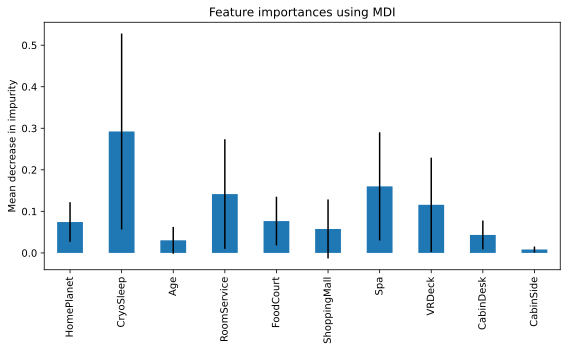

In [196]:
# Feature importances using MDI

model = RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=8,
                           n_estimators=600, random_state=1)

model.fit(train_df, transported)  
prediction = model.predict(test_df)  

importances = model.feature_importances_
feature_names = train_df.columns
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

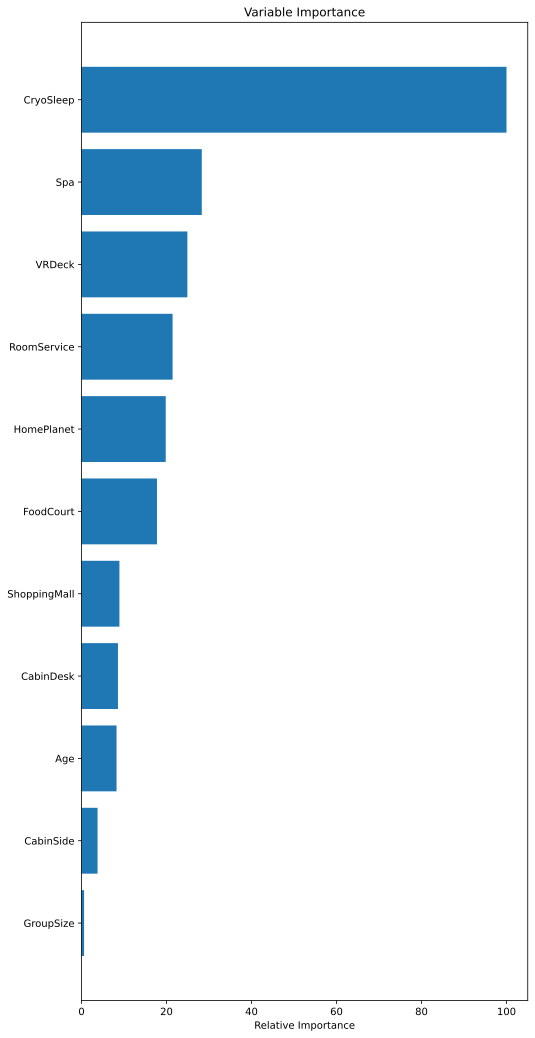

In [34]:
plot_feature_importance(GradientBoostingClassifier(), train_df, transported)

In [35]:
train_df.drop(['GroupSize'], axis=1, inplace=True)
test_df.drop(['GroupSize'], axis=1, inplace=True)

In [41]:
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],'kernel': ['rbf', 'poly']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(train_df, transported)

print(grid.best_estimator_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   4.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   4.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   4.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   4.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   4.8s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   2.7s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   2.7s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   2.7s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   2.7s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   2.7s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   4.7s
[CV] END .......................C=0.1, gamma=0.

[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   4.7s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   4.7s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   4.7s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   4.7s
[CV] END ......................C=10, gamma=0.01, kernel=poly; total time=   2.6s
[CV] END ......................C=10, gamma=0.01, kernel=poly; total time=   2.7s
[CV] END ......................C=10, gamma=0.01, kernel=poly; total time=   2.7s
[CV] END ......................C=10, gamma=0.01, kernel=poly; total time=   2.7s
[CV] END ......................C=10, gamma=0.01, kernel=poly; total time=   2.7s
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=   4.7s
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=   4.7s
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=   4.7s
[CV] END ...................

In [42]:
grid.best_params_

{'C': 100, 'gamma': 1, 'kernel': 'rbf'}

In [37]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression

In [50]:
clf1 = SVC(random_state=1)
clf2 = RandomForestClassifier(n_estimators=600, max_depth=5, min_samples_leaf=2, min_samples_split=8, 
                              random_state=1, n_jobs=-1)
clf3 = GradientBoostingClassifier(n_estimators=100, max_features='auto', learning_rate=0.1, 
                                                              max_depth=4, random_state=1)
clf4 = BaggingClassifier(HistGradientBoostingClassifier(random_state=1), random_state=1, n_jobs=-1)

eclf = VotingClassifier(estimators=[('SVC', clf1), ('rf', clf2), ('gbc', clf3), ('bc', clf4)],
                                   voting='hard', n_jobs=-1)

for clf, label in zip([clf1, clf2, clf3, clf4, eclf], ['SVC', 'Random Forest', 'GradientBoostingClassifier', 'BaggingClassifier', 'Ensemble']):
    scores = cross_val_score(clf, train_df, transported, scoring='accuracy', cv=5)
    print("Accuracy: %0.5f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.79627 (+/- 0.01) [SVC]
Accuracy: 0.78615 (+/- 0.01) [Random Forest]
Accuracy: 0.79950 (+/- 0.01) [GradientBoostingClassifier]
Accuracy: 0.80145 (+/- 0.01) [BaggingClassifier]
Accuracy: 0.79927 (+/- 0.01) [Ensemble]


In [97]:
eclf.fit(train_df, transported)  
prediction = eclf.predict(test_df)  

In [51]:
model = BaggingClassifier(HistGradientBoostingClassifier(random_state=1), random_state=1, n_jobs=-1)

model.fit(train_df, transported)  
prediction = model.predict(test_df)  

In [53]:
model = GradientBoostingClassifier(n_estimators=100, max_features='auto', learning_rate=0.1, 
                                                              max_depth=4, random_state=0)

model.fit(train_df, transported)  
prediction = model.predict(test_df)  

## Score: 0.80476

In [54]:
submission_df['Transported'] = prediction
submission_df['Transported'] = submission_df['Transported'].apply(lambda r: True if r == 1 else False)

submission_df.to_csv('001_GB.csv', index=False)